In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.util

from classy import Class  # CLASS python wrapper
import numpy as np
import matplotlib.pyplot as plt
default_color_list = plt.rcParams['axes.prop_cycle'].by_key()['color'] # get default colors

In [4]:
fiducial_Omega_m = 0.3
fiducial_Omega_b = 0.046
fiducial_h = 0.7
resulting_omega_cdm = (fiducial_Omega_m - fiducial_Omega_b) * (fiducial_h**2)
print('omega_cdm',resulting_omega_cdm)

# create an Observables object to store information for derivatives
obs = Observables(parameters= ['A_s', 'omega_cdm', 'm_ncdm'],
                  fiducial=[2.1e-9, resulting_omega_cdm, 0.0],
                  left=[2.0e-9, resulting_omega_cdm - 0.1, 0.0],
                  right=[2.2e-9, resulting_omega_cdm + 0.1, 0.1])

# generate a template CLASS python wrapper configuration
classy_template = {'output': 'tCl pCl lCl sCl mPk rCl',
                   'l_max_scalars': 10000,
                   'lensing': 'yes',
                   'N_ncdm': 1,
                   'non linear': 'halofit',
                   'selection': 'dirac',
                   'selection_mean' : '1.0, 1.5, 2.0, 2.5',
                   'non_diagonal' : 0,
                   'l_max_lss' : 10000,
                   'accurate_lensing':1,
                   
                   'n_s' : 0.97,
                   'h' : 0.7,

                   'halofit_k_per_decade': 3000.,
#                    'k_max_tau0_over_l_max': 10,
#                    'perturb_sampling_stepsize': 0.01,
#                    'P_k_max_h/Mpc': 50,
#                    'k_per_decade_for_pk': 1000,
#                    'k_per_decade_for_bao': 10000
                  }
# classy_template.update(fishchips.util.PRECISE_CLASS_DICT)
# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

obs.compute_cosmo(key='CLASS_fiducial', classy_dict=classy_template)

omega_cdm 0.12445999999999999


In [5]:
classy_template

{'A_s': 2.1e-09,
 'N_ncdm': 1,
 'accurate_lensing': 1,
 'h': 0.7,
 'halofit_k_per_decade': 3000.0,
 'l_max_lss': 10000,
 'l_max_scalars': 10000,
 'lensing': 'yes',
 'm_ncdm': 0.0,
 'n_s': 0.97,
 'non linear': 'halofit',
 'non_diagonal': 0,
 'omega_cdm': 0.12445999999999999,
 'output': 'tCl pCl lCl sCl mPk rCl',
 'selection': 'dirac',
 'selection_mean': '1.0, 1.5, 2.0, 2.5'}

In [9]:
redshifts = [1.0, 1.5, 2.0, 2.5]
# five_z_grid = obs.grid_cosmo('selection_mean', redshifts, classy_template, verbose=True)

In [7]:
def get_Pkappa(cosmo, source_plane_index=0):
    """
    Extract the convergence power spectrum from a CLASS object.

    This utility function is required because CLASS's `ll` output
    corresponds to the lensing potential power spectrum, which must
    be converted to the lensing convergence/sheer power spectrum with 
    a factor of (ell+2)! / (ell-2)! / 4.

    Parameters
    ----------
        cosmo (CLASS wrapper object) : a computed CLASS cosmology
        source_plane_index (integer) : there can be multiple source
            planes, this parameter specifies which one.

    Returns
    -------
        numpy array : contains the convergence power spectrum 

    """
    cl = cosmo.density_cl()
    ell = cl['ell']
    pref = 0.25 * (ell+2) * (ell+1) * (ell) * (ell-1)
    convergencePS = pref * cl['ll'][source_plane_index]
    return convergencePS

In [ ]:
eV01 = obs.grid_cosmo('m_ncdm', [0.1], classy_template, verbose=True)[0]

/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in true_divide


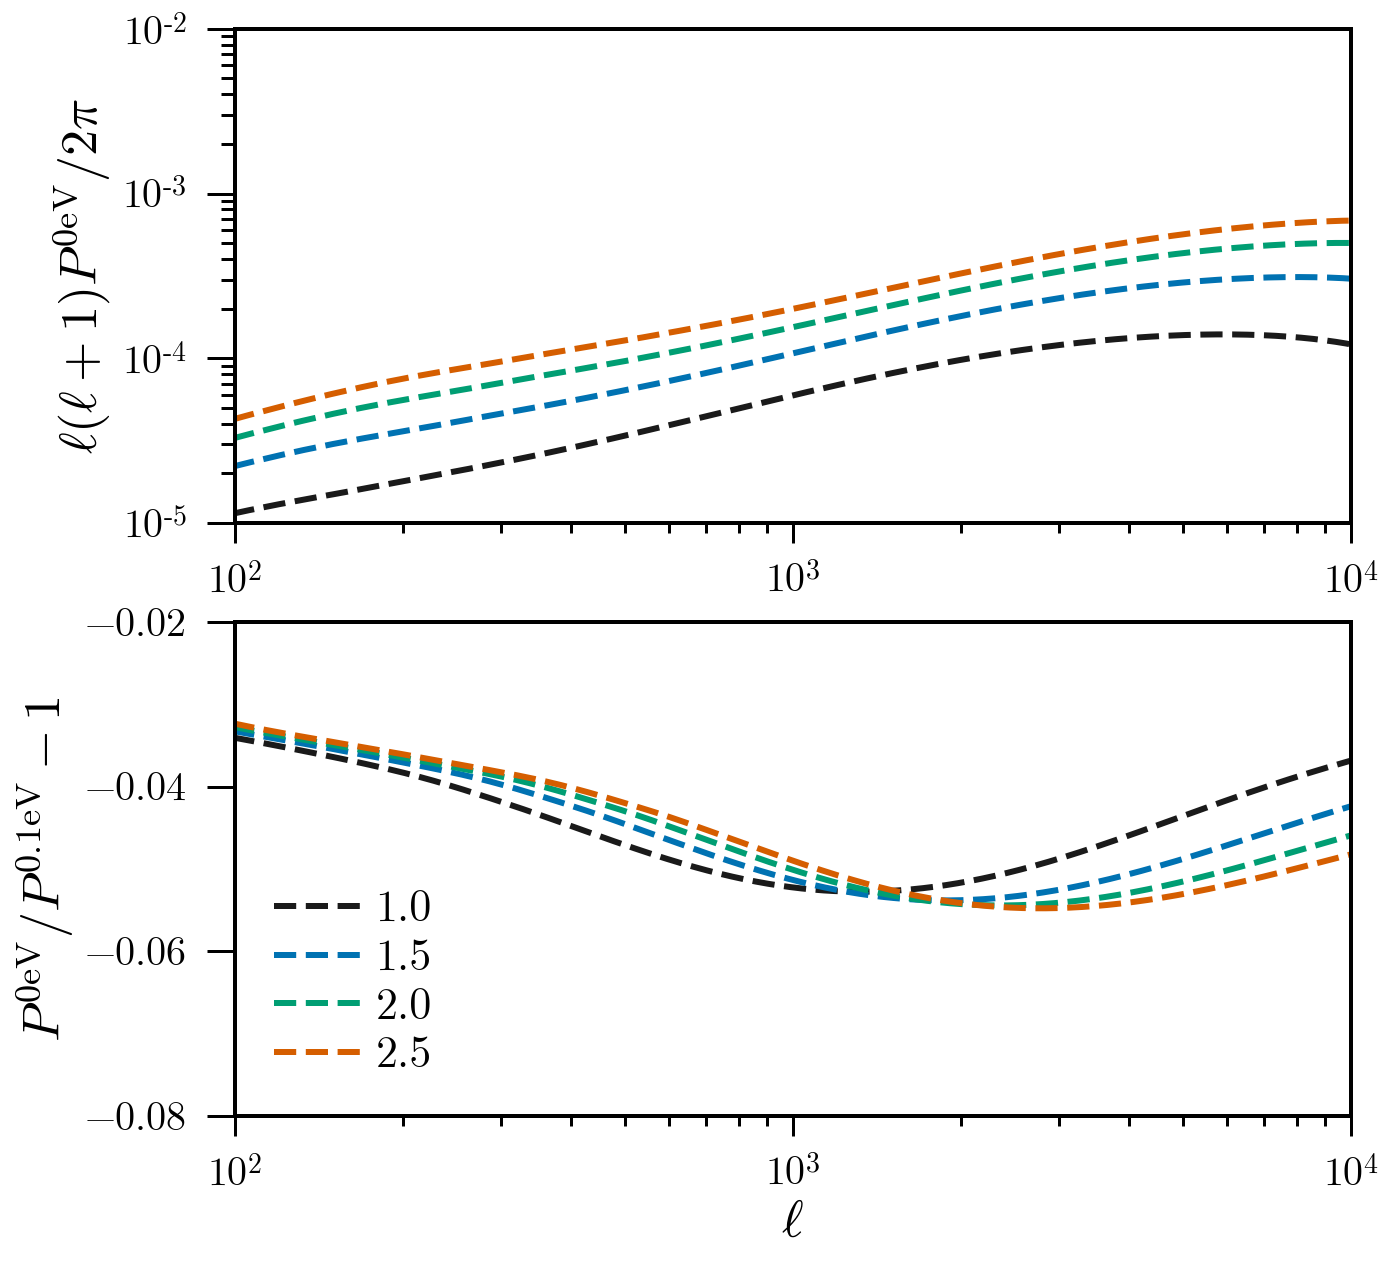

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

fid = obs.cosmos['CLASS_fiducial']
ell = np.arange(10000+1)
prefactor = ell * (ell+1) / (2 * np.pi)

for i, redshift in enumerate(redshifts):
    ax[0].plot( prefactor*get_Pkappa(fid, i), label=f'{redshift}', ls='--', color=default_color_list[i] )

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\ell (\ell+1) P^{\mathrm{0eV}} / 2 \pi$')
# ax[0].set_xlabel(r'$\ell$')
ax[0].set_xlim(1e2,1e4)
ax[0].set_ylim(1e-5,1e-2)
# plt.legend()


fid = obs.cosmos['CLASS_fiducial']
ell = np.arange(10000+1)
prefactor = ell * (ell+1) / (2 * np.pi)

for i, redshift in enumerate(redshifts):
    ax[1].plot( get_Pkappa(eV01, i)/get_Pkappa(fid, i) - 1, label=f'{redshift}', ls='--', color=default_color_list[i] )

ax[1].set_xscale('log')
ax[1].set_ylabel(r'$P^{\mathrm{0eV}} /P^{\mathrm{0.1eV}} - 1$')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_xlim(1e2,1e4)
ax[1].set_ylim(-0.08,-0.02)
ax[1].set_yticks([-0.02, -0.04, -0.06, -0.08])
ax[1].legend()

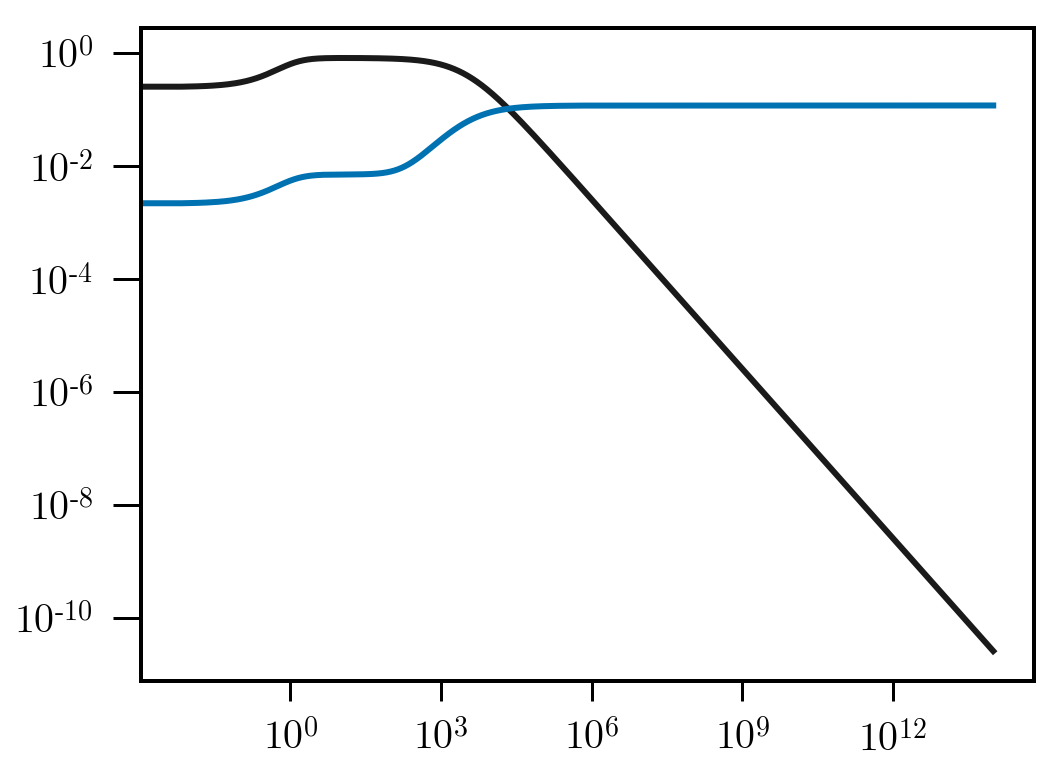

In [109]:
z = eV01.get_background()['z']
plt.plot( z, eV01.get_background()['(.)rho_cdm'] 
         / eV01.get_background()['(.)rho_crit'] )

plt.plot( z, eV01.get_background()['(.)rho_ncdm[0]'] 
         / eV01.get_background()['(.)rho_crit'] )
plt.yscale('log')
plt.xscale('log')

## Load in Sim Data

In [23]:
from maystats import *


gp_list = []

def build_GP( params, ell, ps_mean, 
             PS_scale = 1e-9 ):
    global gp_list
    gp_list = []
    for test_ell_bin in range(len(ell)):
        X = np.array([table['M_nu(eV)'], 
                      table['Omega_m'], 
                      table['10^9*A_s']])
        X = np.atleast_2d(X).T
        y = np.array([np.mean(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
        dy = np.array([sem(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
        kernel =  C( 1.0, (1e-3, 1e3))  * RBF( np.ones(3), (1e-5, 1e5))
        gp = GaussianProcessRegressor(kernel=kernel, 
                                      alpha=(dy)**2, 
                                      n_restarts_optimizer=10,
                                      normalize_y=True)
        gp.fit(X, y)
        gp_list.append(gp)

    def get_PS_( x ):
        y_pred_list = []
        sigma_list = []
        for gp in gp_list:
            y_pred, sigma = gp.predict( np.atleast_2d(x), return_std=True)
            y_pred_list.append(y_pred[0])
            sigma_list.append(sigma[0])

        return np.array(y_pred_list), np.array(sigma_list)
    
    return get_PS_


In [96]:
def get_fids(redshift):
    params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])

    ell_list = []
    ps_real_list = []
    redshifts = [redshift]
    for redshift in redshifts:
        ell_, ps_real_ = get_real_list( 'PS', noisy='KN', redshift=redshift,  
                                       bin_min=2, bin_max=10000, smoothing='1.00', binscale='log' )
        ell_list.append(ell_)
        ps_real_list.append(ps_real_)

    ell = np.hstack(ell_list)
    ps_real = np.dstack(ps_real_list)

#     invcov = 1e-18*get_invcov( 'PS', noisy='K', redshifts=redshifts, 
#                                        bin_min=2, bin_max=10000, smoothing='1.00', binscale='log')
    # get_PS = build_GP( params, ell, ps_real )

    fidell = ell_list[0]
    prefactor = fidell * (fidell+1) / (2 * np.pi)
    fidA = np.mean( ps_real_list[0][0], axis=0 )
    fidB = np.mean( ps_real_list[0][1], axis=0 )
    print(len(ps_real_list[0]))
    return fidA, fidB, fidell

In [97]:
redshifts = [1.0, 1.5, 2.0, 2.5]
sim_redshifts = ['10', '15', '20', '25']

101
101
101
101
101


/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


101
101
101


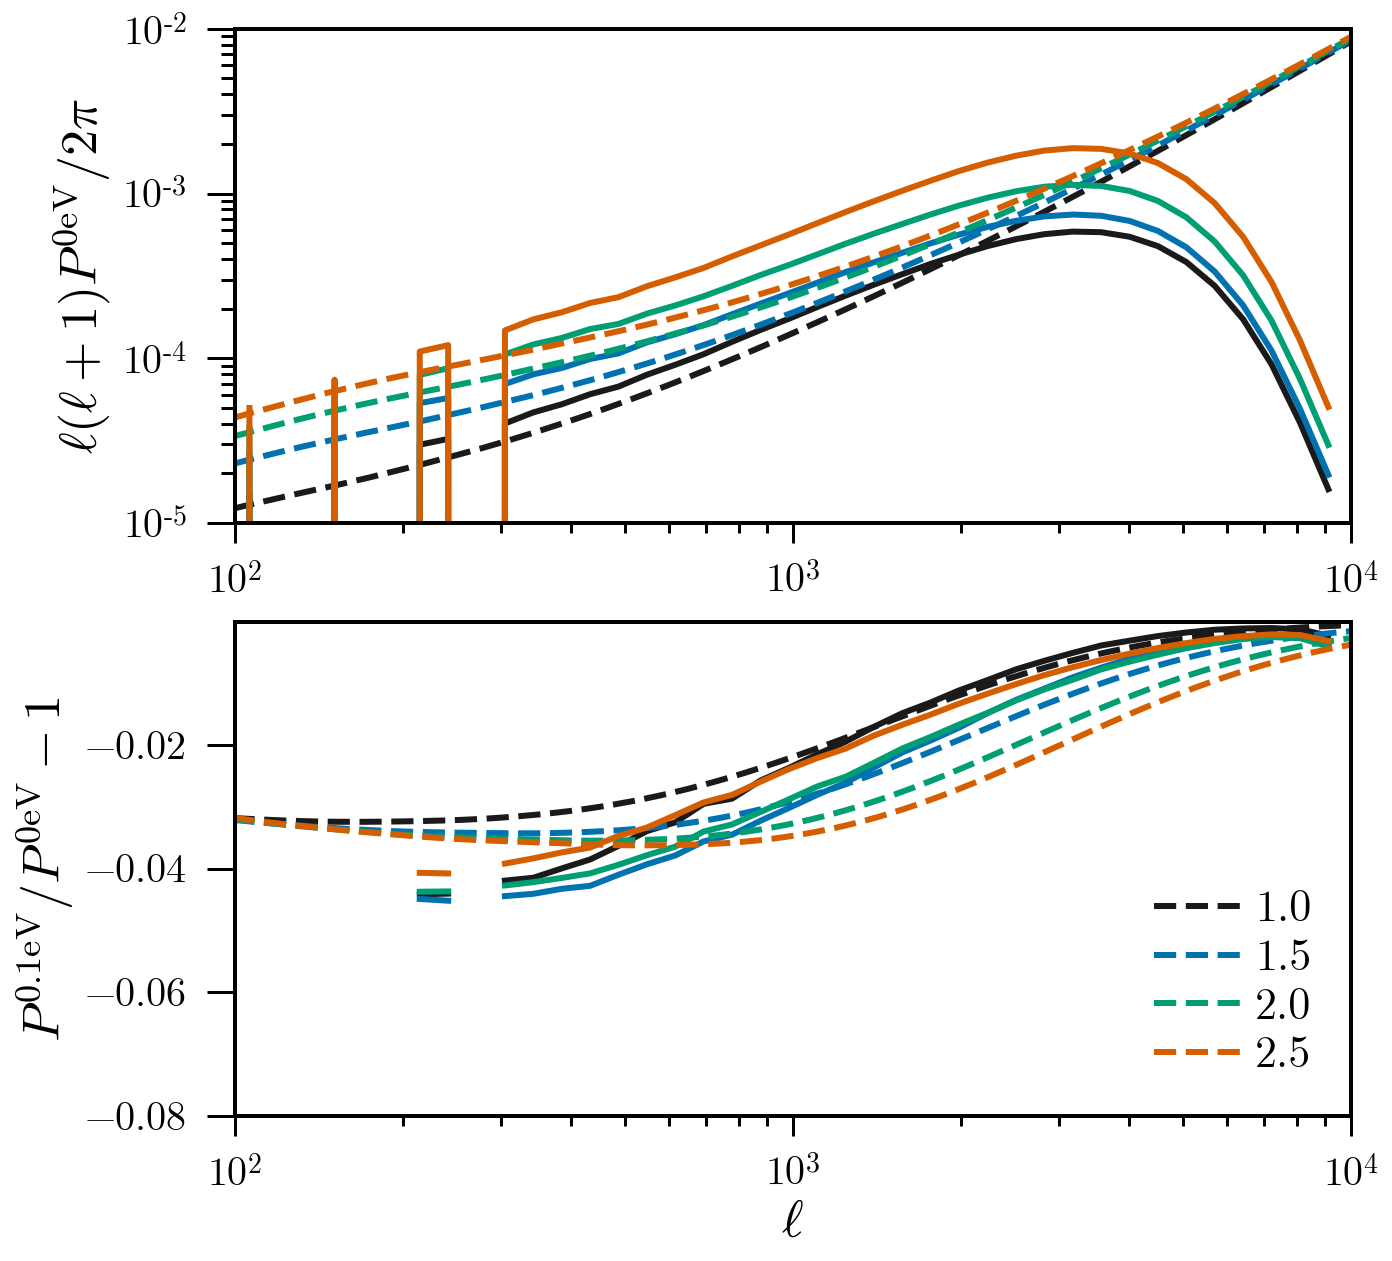

In [99]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

fid = obs.cosmos['CLASS_fiducial']
ell = np.arange(10000+1)
prefactor = ell * (ell+1) / (2 * np.pi)

nl = 2 * (0.35**2 / (40 * 3437.75**2)  )


for i, (redshift, sim_redshift) in enumerate(zip(redshifts, sim_redshifts)):
    ax[0].plot( prefactor*(get_Pkappa(fid, i)+nl), label=f'{redshift}', ls='--', color=default_color_list[i] )
    fidA, fidB, fidell = get_fids(sim_redshift)
    ax[0].plot( fidell, fidA * fidell * (fidell+1) / (2 * np.pi), ls='-', color=default_color_list[i] )

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\ell (\ell+1) P^{\mathrm{0eV}} / 2 \pi$')
# ax[0].set_xlabel(r'$\ell$')
ax[0].set_xlim(1e2,1e4)
ax[0].set_ylim(1e-5,1e-2)
# plt.legend()

 
fid = obs.cosmos['CLASS_fiducial']
ell = np.arange(10000+1)
prefactor = ell * (ell+1) / (2 * np.pi)

for i, (redshift, sim_redshift) in enumerate(zip(redshifts, sim_redshifts)):
    ax[1].plot( (get_Pkappa(eV01, i) + nl)/(get_Pkappa(fid, i) + nl) - 1, label=f'{redshift}', ls='--', color=default_color_list[i] )
    fidA, fidB, fidell = get_fids(sim_redshift)
    ax[1].plot( fidell, fidB / fidA - 1, ls='-', color=default_color_list[i] )

ax[1].set_xscale('log')
ax[1].set_ylabel(r'$P^{\mathrm{0.1eV}} /P^{\mathrm{0eV}} - 1$')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_xlim(1e2,1e4)
ax[1].set_ylim(-0.08,-0.00)
ax[1].set_yticks([-0.02, -0.04, -0.06, -0.08])
ax[1].legend()